<a href="https://colab.research.google.com/github/gregorylira/Diffusion-models/blob/main/class_conditioned_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class-Conditioned Diffusion Model


## Setup and Data Prep

In [1]:
%pip install -q diffusers

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [112]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


# Mnist

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 1, 7, 3, 9, 4, 6, 1])


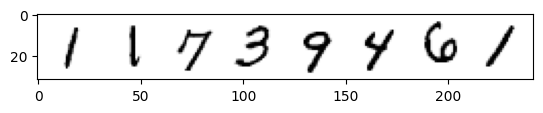

In [2]:
# Load the dataset
dataset = torchvision.datasets.MNIST(root="data/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## Creating a Class-Conditioned UNet

In [3]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

If any of the shapes or transforms are confusing, add in print statements to show the relevant shapes and check that they match your expectations. I've also annotated the shapes of some intermediate variables in the hopes of making things clearer.

## Training and Sampling



In [4]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

100%|██████████| 469/469 [01:31<00:00,  5.10it/s]


Finished epoch 0. Average of the last 100 loss values: 0.052790


1000it [00:23, 42.29it/s]


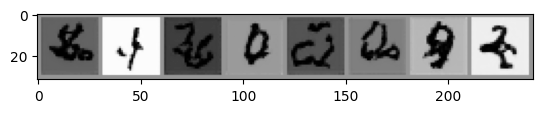

100%|██████████| 469/469 [01:31<00:00,  5.11it/s]


Finished epoch 1. Average of the last 100 loss values: 0.045625


1000it [00:23, 43.12it/s]


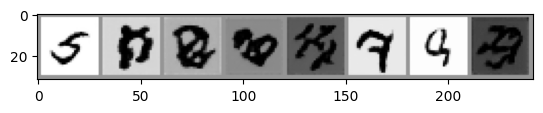

100%|██████████| 469/469 [01:32<00:00,  5.07it/s]


Finished epoch 2. Average of the last 100 loss values: 0.044480


1000it [00:22, 43.70it/s]


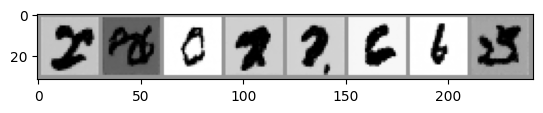

100%|██████████| 469/469 [01:32<00:00,  5.06it/s]


Finished epoch 3. Average of the last 100 loss values: 0.042640


1000it [00:22, 43.98it/s]


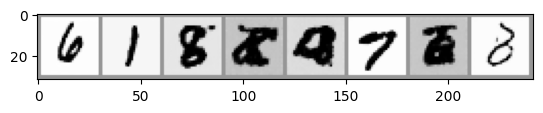

100%|██████████| 469/469 [01:31<00:00,  5.11it/s]


Finished epoch 4. Average of the last 100 loss values: 0.041157


1000it [00:22, 45.20it/s]


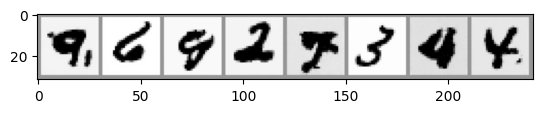

100%|██████████| 469/469 [01:31<00:00,  5.12it/s]


Finished epoch 5. Average of the last 100 loss values: 0.041073


1000it [00:22, 44.78it/s]


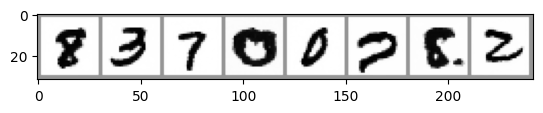

100%|██████████| 469/469 [01:31<00:00,  5.11it/s]


Finished epoch 6. Average of the last 100 loss values: 0.039464


1000it [00:22, 45.14it/s]


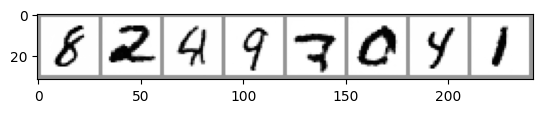

100%|██████████| 469/469 [01:31<00:00,  5.10it/s]


Finished epoch 7. Average of the last 100 loss values: 0.039172


1000it [00:23, 43.14it/s]


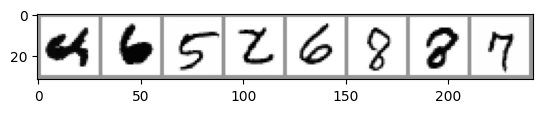

100%|██████████| 469/469 [01:31<00:00,  5.12it/s]


Finished epoch 8. Average of the last 100 loss values: 0.039272


1000it [00:22, 44.38it/s]


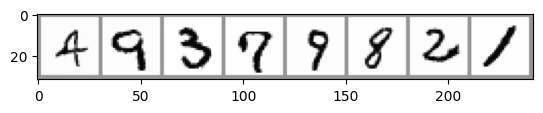

100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


Finished epoch 9. Average of the last 100 loss values: 0.039291


1000it [00:22, 44.51it/s]


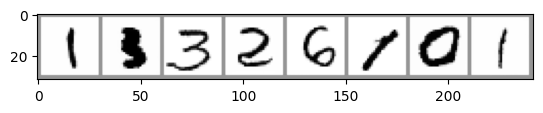

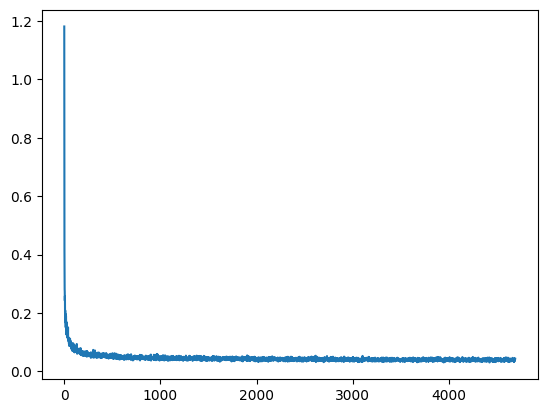

In [10]:
# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

    with torch.no_grad():
        x = torch.randn(8, 1, 28, 28).to(device)
        y = torch.tensor([i for i in range(8)]).to(device)

        plot_images = []
        
        for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
            residual = net(x, t, y)
            x = noise_scheduler.step(residual, t, x).prev_sample

        
        plt.imshow(torchvision.utils.make_grid(x.cpu())[-1], cmap='Greys')
        print(y)
        plt.show()

# View the loss curve
plt.plot(losses)

In [12]:
# save model
torch.save(net.state_dict(), 'models/unet_mnist_model.pth')

In [5]:
#load model
net = ClassConditionedUnet().to(device)
net.load_state_dict(torch.load('models/unet_mnist_model.pth'))

<All keys matched successfully>

1000it [00:33, 30.13it/s]


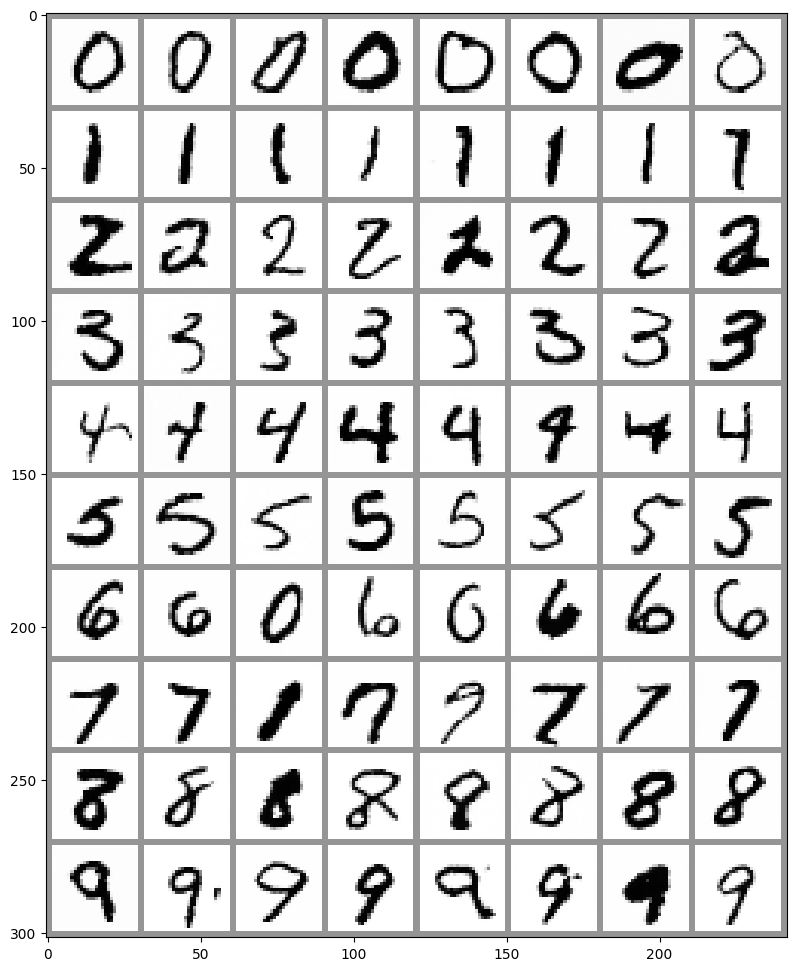

In [6]:
# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

# FashionMnist

In [ ]:
# todo: Try this with FashionMNIST. Tweak the learning rate, batch size and number of epochs.
# Can you get some decent-looking fashion images with less training time than the example above?

100%|██████████| 26421880/26421880 [00:02<00:00, 12060688.48it/s]


Extracting mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 190974.88it/s]


Extracting mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 663843.69it/s] 


Extracting mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5881851.54it/s]


Extracting mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 5, 6, 6, 9, 9, 9, 0])


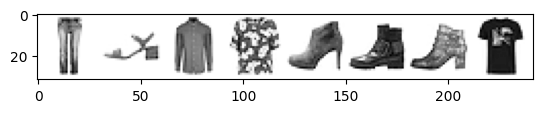

In [ ]:
dataset = torchvision.datasets.FashionMNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [ ]:
len(dataset.classes)

10

In [ ]:
class ClassConditionedUnetFashionMNIST(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [44]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [45]:
bs = 64
n_epochs = 10
train_dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_fn = nn.MSELoss()
net = ClassConditionedUnetFashionMNIST().to(device)
losses = []
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(n_epochs):
  for x, y in tqdm(train_dataloader):
    x = x.to(device)
    y = y.to(device)
    noise = torch.randn_like(x)
    timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
    noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

    pred = net(noisy_x, timesteps, y)
    loss = loss_fn(pred, noise)

    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())

  avg_loss = sum(losses[-100:])/100
  print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

plt.plot(losses)



NameError: name 'ClassConditionedUnetFashionMNIST' is not defined

0it [00:00, ?it/s]

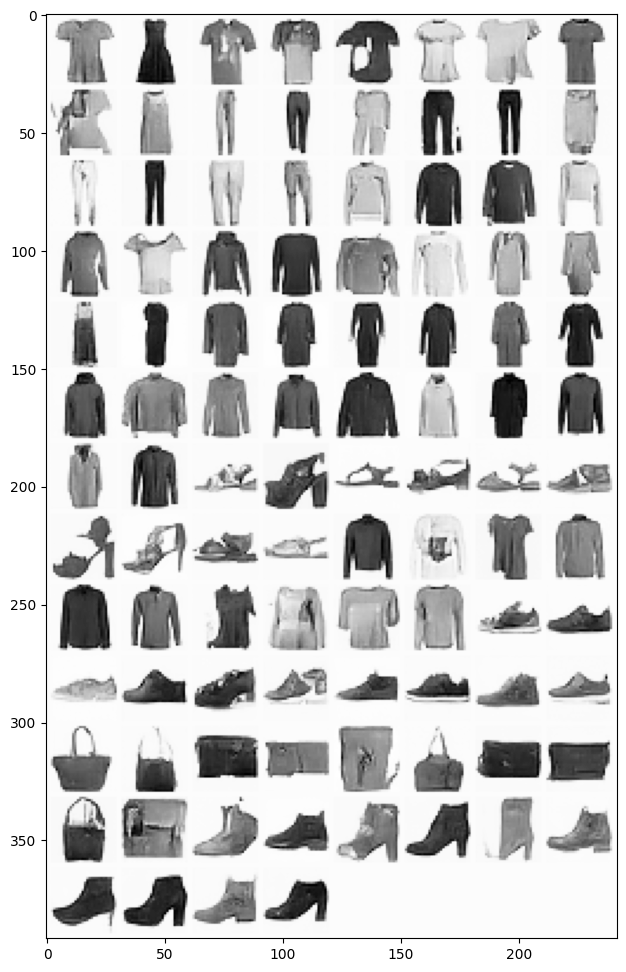

In [ ]:
x = torch.randn(100, 1, 28, 28).to(device)
y = torch.tensor([[i]*10 for i in range(10)]).flatten().to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
  with torch.no_grad():
    residual = net(x, t, y)

  x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

0it [00:00, ?it/s]

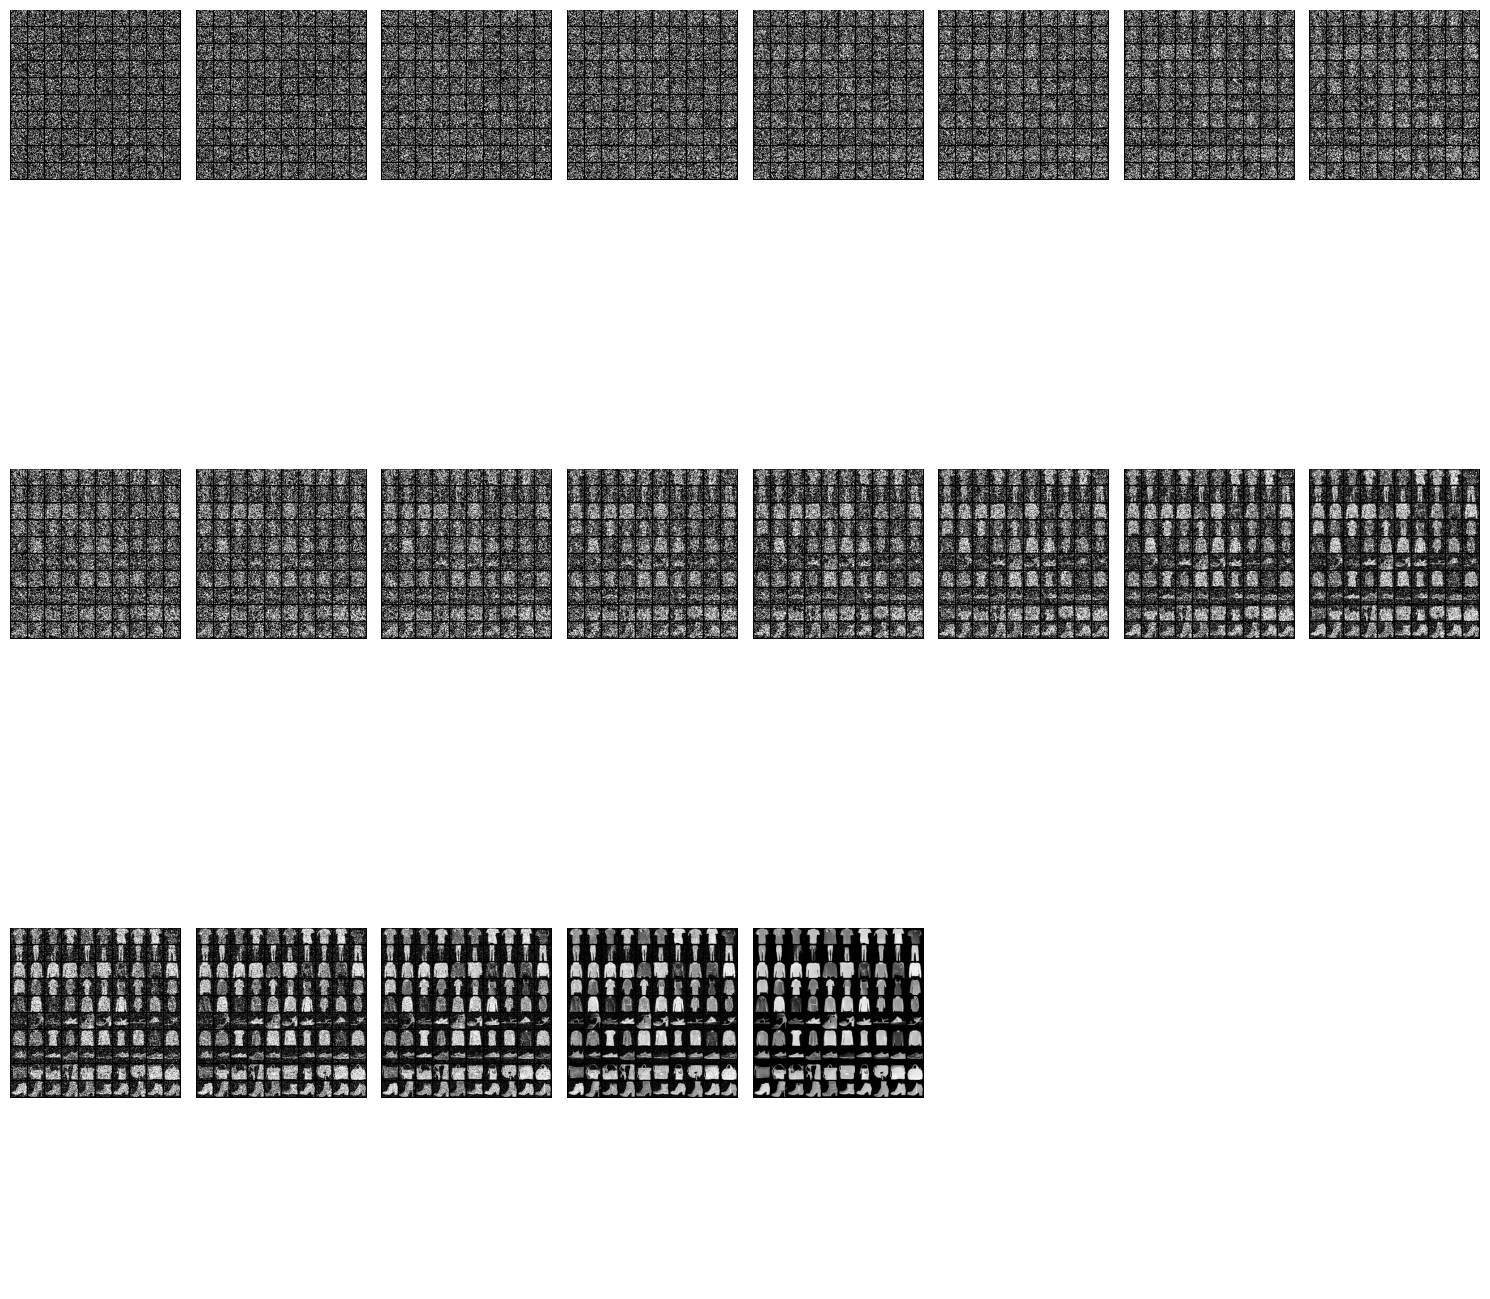

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

x = torch.randn(100, 1, 28, 28).to(device)
y = torch.tensor([[i] * 10 for i in range(10)]).flatten().to(device)

images = []

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)

    x = noise_scheduler.step(residual, t, x).prev_sample

    if i % 50 == 0 or i == len(noise_scheduler.timesteps) - 1:
        images.append(x.detach().cpu().clone())

num_images = len(images)
num_cols = 8  # Número de colunas
num_rows = (num_images + num_cols - 1) // num_cols  # Calcula o número de linhas necessário

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Facilita a iteração

for idx, img in enumerate(images):
    # Ajusta o grid para 10 colunas
    axes[idx].imshow(torchvision.utils.make_grid(img.clip(-1, 1), nrow=10).permute(1, 2, 0), cmap='Greys')
    axes[idx].axis('off')

# Remove eixos extras se houver menos imagens que o número de subplots
for idx in range(num_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os

# Diretório para salvar as imagens
output_dir = "timesteps_images"
os.makedirs(output_dir, exist_ok=True)

# Gera entradas aleatórias e rótulos
x = torch.randn(100, 1, 28, 28).to(device)
y = torch.tensor([[i] * 10 for i in range(10)]).flatten().to(device)

# Loop sobre os timesteps e salva o estado de `x` periodicamente
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)

    # Atualiza o `x`
    x = noise_scheduler.step(residual, t, x).prev_sample

    # Salva o estado de `x` a cada 50 etapas
    if i % 50 == 0 or i == len(noise_scheduler.timesteps) - 1:
        # Define o nome do arquivo
        filename = os.path.join(output_dir, f"step_{i}.png")

        # Cria a grid das imagens
        grid_img = torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=10)

        # Salva a imagem
        plt.figure(figsize=(12, 12))
        plt.imshow(grid_img.permute(1, 2, 0), cmap='Greys')
        plt.axis('off')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close()


0it [00:00, ?it/s]

In [ ]:
!zip -r timesteps_images.zip timesteps_images

  adding: timesteps_images/ (stored 0%)
  adding: timesteps_images/step_850.png (deflated 7%)
  adding: timesteps_images/step_800.png (deflated 7%)
  adding: timesteps_images/step_400.png (deflated 9%)
  adding: timesteps_images/step_600.png (deflated 8%)
  adding: timesteps_images/step_50.png (deflated 8%)
  adding: timesteps_images/step_350.png (deflated 9%)
  adding: timesteps_images/step_150.png (deflated 7%)
  adding: timesteps_images/step_250.png (deflated 7%)
  adding: timesteps_images/step_300.png (deflated 8%)
  adding: timesteps_images/step_700.png (deflated 7%)
  adding: timesteps_images/step_200.png (deflated 8%)
  adding: timesteps_images/step_100.png (deflated 7%)
  adding: timesteps_images/step_650.png (deflated 8%)
  adding: timesteps_images/step_500.png (deflated 8%)
  adding: timesteps_images/step_900.png (deflated 7%)
  adding: timesteps_images/step_999.png (deflated 8%)
  adding: timesteps_images/step_450.png (deflated 9%)
  adding: timesteps_images/step_750.png (de

# CIFAR-10

100%|██████████| 170498071/170498071 [00:04<00:00, 42354627.55it/s]


Extracting cifar/cifar-10-python.tar.gz to cifar/
Input shape: torch.Size([8, 3, 32, 32])
Labels: tensor([2, 6, 3, 8, 3, 2, 7, 4])


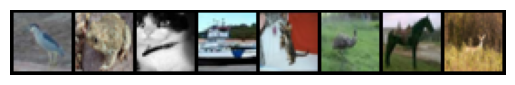

In [ ]:
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Converte as imagens para tensor e normaliza para [0, 1]
])

dataset = torchvision.datasets.CIFAR10(root="cifar/", train=True, download=True, transform=transform)

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))

print('Input shape:', x.shape)
print('Labels:', y)

grid_img = torchvision.utils.make_grid(x)

grid_img = grid_img.permute(1, 2, 0).numpy()
# grid_img = (grid_img - grid_img.min()) / (grid_img.max() - grid_img.min())  # Ajusta o intervalo para [0, 1]

plt.imshow(grid_img)
plt.axis('off')  # Oculta os eixos
plt.show()


In [ ]:
len(dataset.classes)

10

In [ ]:
import torch
import torch.nn as nn
from transformers import UNet2DModel 

class AdvancedClassConditionedUnetCifar10(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=16):
        super().__init__()

        # Embedding layer maps class labels to vectors of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Define the UNet model with additional complexity
        self.model = UNet2DModel(
            sample_size=32,                    # Target image resolution
            in_channels=3 + class_emb_size,    # Additional channels for class conditioning
            out_channels=3,                    # Number of output channels
            layers_per_block=2,                # Layers per ResNet block
            block_out_channels=(64, 128, 256, 512),  # Increased depth
            down_block_types=(
                "DownBlock2D",                # Regular ResNet downsampling block
                "AttnDownBlock2D",            # ResNet downsampling with spatial attention
                "AttnDownBlock2D",
                "AttnDownBlock2D"             # Additional downsampling block with attention
            ),
            up_block_types=(
                "AttnUpBlock2D",              # ResNet upsampling with spatial attention
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D"                    # Additional upsampling block without attention
            ),
            dropout_rate=0.5,                  # Dropout rate to improve generalization
            use_batch_norm=True                # Use batch normalization
        )

    def forward(self, x, t, class_labels):
        # Shape of x: (batch_size, channels, width, height)
        bs, ch, w, h = x.shape

        # Map class labels to embeddings and adjust shape for concatenation
        class_cond = self.class_emb(class_labels)  # Get class embeddings
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)

        # Concatenate input image and class embeddings
        net_input = torch.cat((x, class_cond), 1)

        # Feed the concatenated input to the UNet model
        return self.model(net_input, t).sample


In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [ ]:
def show_image(image_tensor, title=""):
    if image_tensor.dim() == 4:  # Tensor de forma (batch_size, channels, height, width)
        image_tensor = image_tensor[0]  # Pegue a primeira imagem do batch
    elif image_tensor.dim() != 3:
        raise ValueError(f"Unexpected number of dimensions: {image_tensor.dim()}")

    image = image_tensor.permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()


  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.041436
tensor(-3.5558, device='cuda:0') tensor(3.9740, device='cuda:0')
tensor(-3.5558, device='cuda:0') tensor(3.9740, device='cuda:0')


0it [00:00, ?it/s]

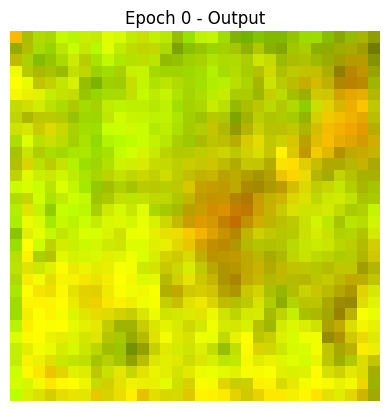

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.038281
tensor(-3.3452, device='cuda:0') tensor(3.3091, device='cuda:0')
tensor(-3.3452, device='cuda:0') tensor(3.3091, device='cuda:0')


0it [00:00, ?it/s]

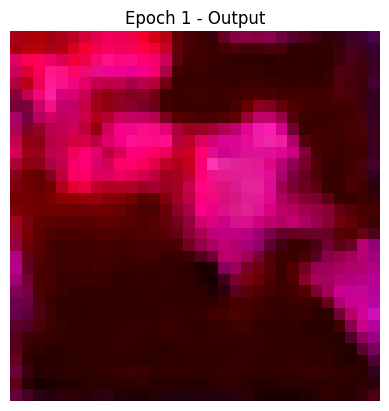

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.037778
tensor(-3.4625, device='cuda:0') tensor(3.6896, device='cuda:0')
tensor(-3.4625, device='cuda:0') tensor(3.6896, device='cuda:0')


0it [00:00, ?it/s]

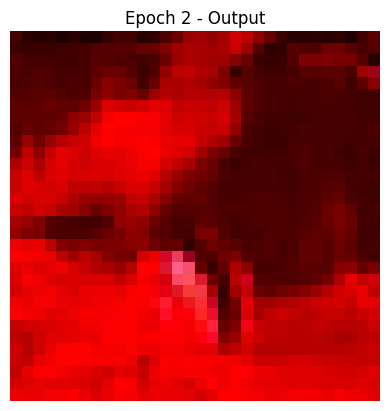

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.037113
tensor(-3.3960, device='cuda:0') tensor(3.1619, device='cuda:0')
tensor(-3.3960, device='cuda:0') tensor(3.1619, device='cuda:0')


0it [00:00, ?it/s]

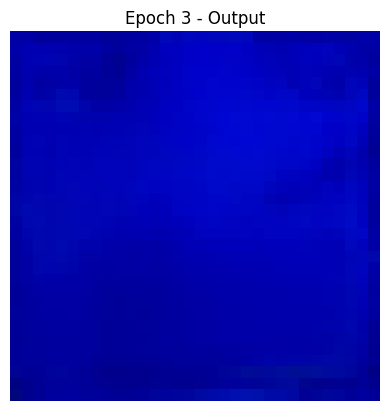

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.036025
tensor(-3.8677, device='cuda:0') tensor(3.5667, device='cuda:0')
tensor(-3.8677, device='cuda:0') tensor(3.5667, device='cuda:0')


0it [00:00, ?it/s]

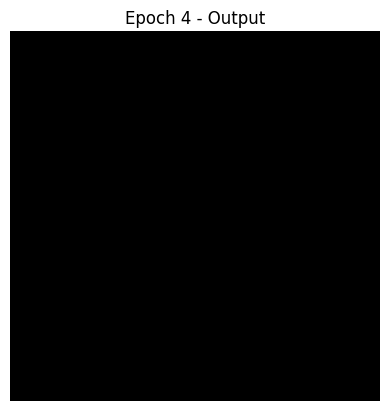

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.037287
tensor(-3.3986, device='cuda:0') tensor(3.1607, device='cuda:0')
tensor(-3.3986, device='cuda:0') tensor(3.1607, device='cuda:0')


0it [00:00, ?it/s]

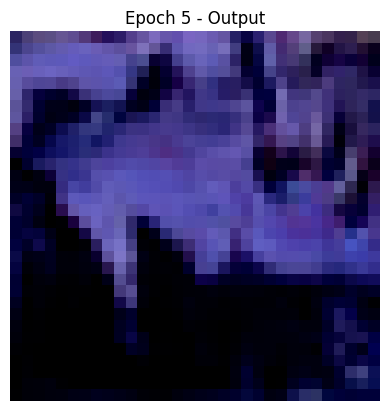

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.035967
tensor(-3.2210, device='cuda:0') tensor(3.1578, device='cuda:0')
tensor(-3.2210, device='cuda:0') tensor(3.1578, device='cuda:0')


0it [00:00, ?it/s]

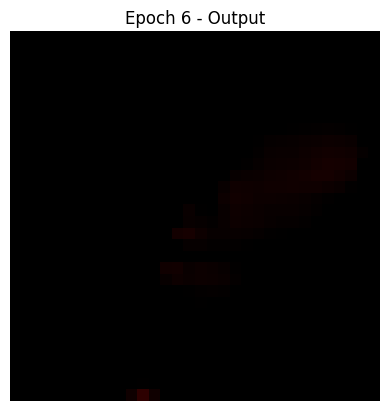

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.036781
tensor(-4.1683, device='cuda:0') tensor(3.7228, device='cuda:0')
tensor(-4.1683, device='cuda:0') tensor(3.7228, device='cuda:0')


0it [00:00, ?it/s]

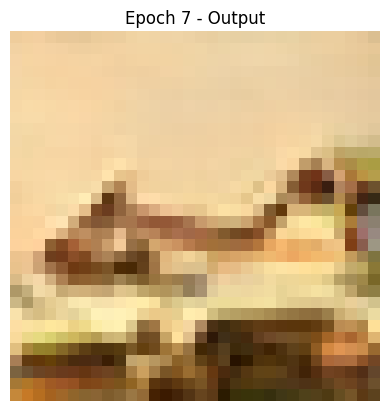

  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
bs = 64
n_epochs = 50
train_dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_fn = nn.MSELoss()
net = ClassConditionedUnetCifar10().to(device)
losses = []
opt = torch.optim.Adam(net.parameters(), lr=1e-3)




for epoch in range(n_epochs):
  for x, y in tqdm(train_dataloader):
    x = x.to(device)
    y = y.to(device)

    noise = torch.randn_like(x)
    timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
    noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
    pred = net(noisy_x, timesteps, y)
    loss = loss_fn(pred, noise)

    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())

  avg_loss = sum(losses[-100:])/100
  print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')


  with torch.no_grad():
    x = torch.randn(1, 3, 32, 32).to(device)
    # x = (x - x.min()) / (x.max() - x.min())  # Normaliza para [0, 1]
    print(x.min(),x.max())
    y = torch.tensor([1]).flatten().to(device)


    print(x.min(), x.max())

    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
      with torch.no_grad():
        residual = net(x, t, y)

      x = noise_scheduler.step(residual, t, x).prev_sample

    show_image(x[-1], title=f'Epoch {epoch} - Output')

plt.plot(losses)


0it [00:00, ?it/s]

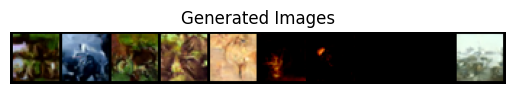

In [ ]:
x = torch.randn(10, 3, 32, 32).to(device)
x = (x - x.min()) / (x.max() - x.min())  # Normaliza para [0, 1]

y = torch.tensor([[i] * 1 for i in range(10)]).flatten().to(device)

# Geração de imagens
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)

    x = noise_scheduler.step(residual, t, x).prev_sample

def show_image(tensor, title=None):
    image = tensor.cpu().detach()
    image = torchvision.utils.make_grid(image, nrow=10)
    image = image.permute(1, 2, 0).clamp([0,1]).numpy()  # Ajusta o intervalo para [0, 1]
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

show_image(x, title='Generated Images')


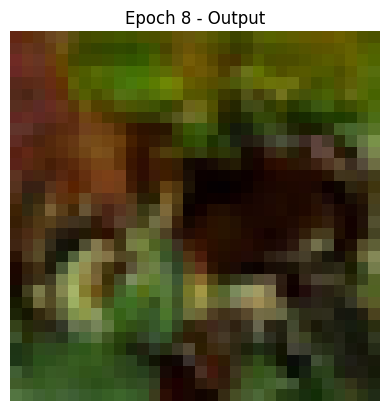

In [ ]:
show_image(x[2], title=f'Epoch {epoch} - Output')

0it [00:00, ?it/s]

Image stats - min: -1.0, max: 1.0


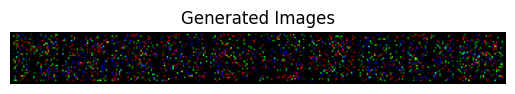

torch.Size([10, 3, 32, 32])

In [ ]:
x = torch.randn(10, 3, 32, 32).to(device)
x = (x - x.min()) / (x.max() - x.min())  # Normaliza para [0, 1]
y = torch.tensor([[i] * 1 for i in range(10)]).flatten().to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
  with torch.no_grad():
    residual = net(x, t, y)

  x = noise_scheduler.step(residual, t, x).prev_sample

def show_image(tensor, title=None):
    image = tensor.cpu().detach()
    image = torchvision.utils.make_grid(image, nrow=10)
    # Verifique os valores máximos e mínimos da imagem antes da normalização
    print(f"Image stats - min: {image.min()}, max: {image.max()}")
    image = image.permute(1, 2, 0).clamp(0, 1).numpy()  # Ajusta o intervalo
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


show_image(x, title='Generated Images')

x.shape


In [ ]:
from torchvision import transforms

class AdvancedClassConditionedUnetCifar10(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=16):
        super().__init__()

        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=32,
            in_channels=3 + class_emb_size,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D"
            ),

        )

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        class_cond = self.class_emb(class_labels)
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        net_input = torch.cat((x, class_cond), 1)
        return self.model(net_input, t).sample

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = torchvision.datasets.CIFAR10(root="data/", train=True, download=True, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Plot example images
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)

grid_img = torchvision.utils.make_grid(x)
grid_img = grid_img.permute(1, 2, 0).numpy()
plt.imshow(grid_img)
plt.axis('off')
plt.show()


noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bs = 64
n_epochs = 50
train_dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_fn = nn.MSELoss()
net = AdvancedClassConditionedUnetCifar10().to(device)
losses = []
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        x = x.to(device)
        y = y.to(device)

        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 1000, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        pred = net(noisy_x, timesteps, y)
        loss = loss_fn(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:.5f}')

    with torch.no_grad():
        x = torch.randn(8, 3, 32, 32).to(device)
        y = torch.randint(0, 10, (8,)).to(device)

        for t in tqdm(noise_scheduler.timesteps):
            residual = net(x, t, y)
            x = noise_scheduler.step(residual, t, x, return_dict=True).prev_sample

        # normalize each channel to [0, 1]
        x = (x - x.min()) / (x.max() - x.min())
        # 0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck
        print('Labels:', y)
        plt.imshow(torchvision.utils.make_grid(x.cpu()).permute(1, 2, 0))
        plt.axis('off')
        plt.show()

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


# StanfordCars

In [2]:
def show_images_dataset(dataset, num_samples=20, col=4):
    """Plots some samples from the dataset."""
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(dataset):
        if i >= num_samples:
            break
        plt.subplot(num_samples // col, col, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')

In [3]:



class StanfordCars(torch.utils.data.Dataset):
    def __init__(self, root_path, transform=None):
        self.images = [os.path.join(root_path, file) for file in os.listdir(root_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_file = self.images[index]
        try:
            image = Image.open(image_file).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")
            return None
        
        if self.transform:
            image = self.transform(image)
        
        return image


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensiona as imagens para 256x256 pixels
    transforms.ToTensor()
])

# Example usage
dataset = StanfordCars(root_path="data/cars_train/cars_train", transform=transform)


In [4]:
dataload = DataLoader(dataset, batch_size=8, shuffle=True)
xb = next(iter(dataload))
print(xb.shape)

torch.Size([8, 3, 256, 256])


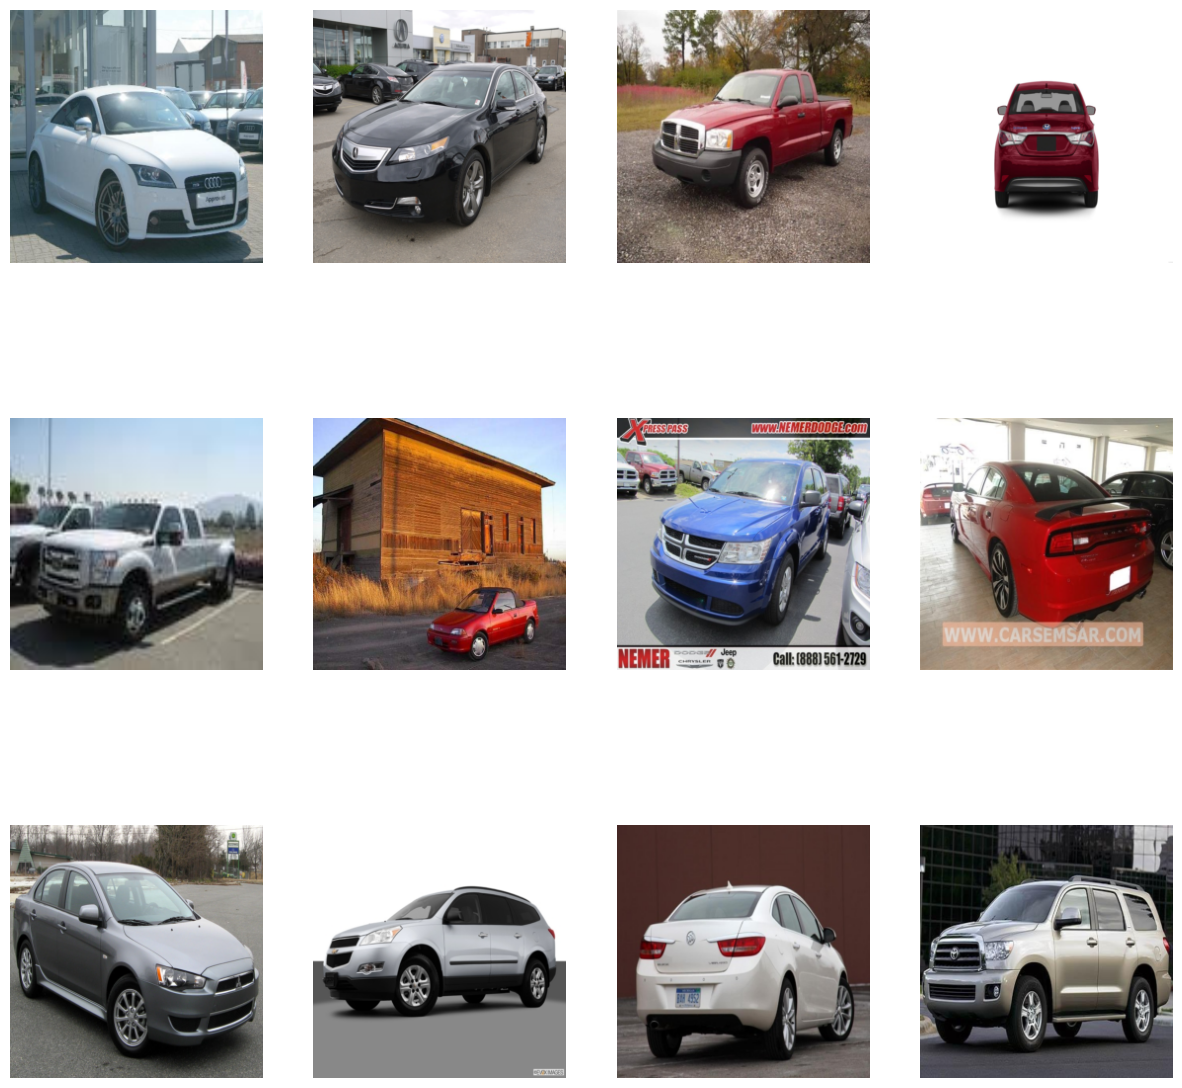

In [5]:
show_images_dataset(dataset, num_samples=12, col=4)

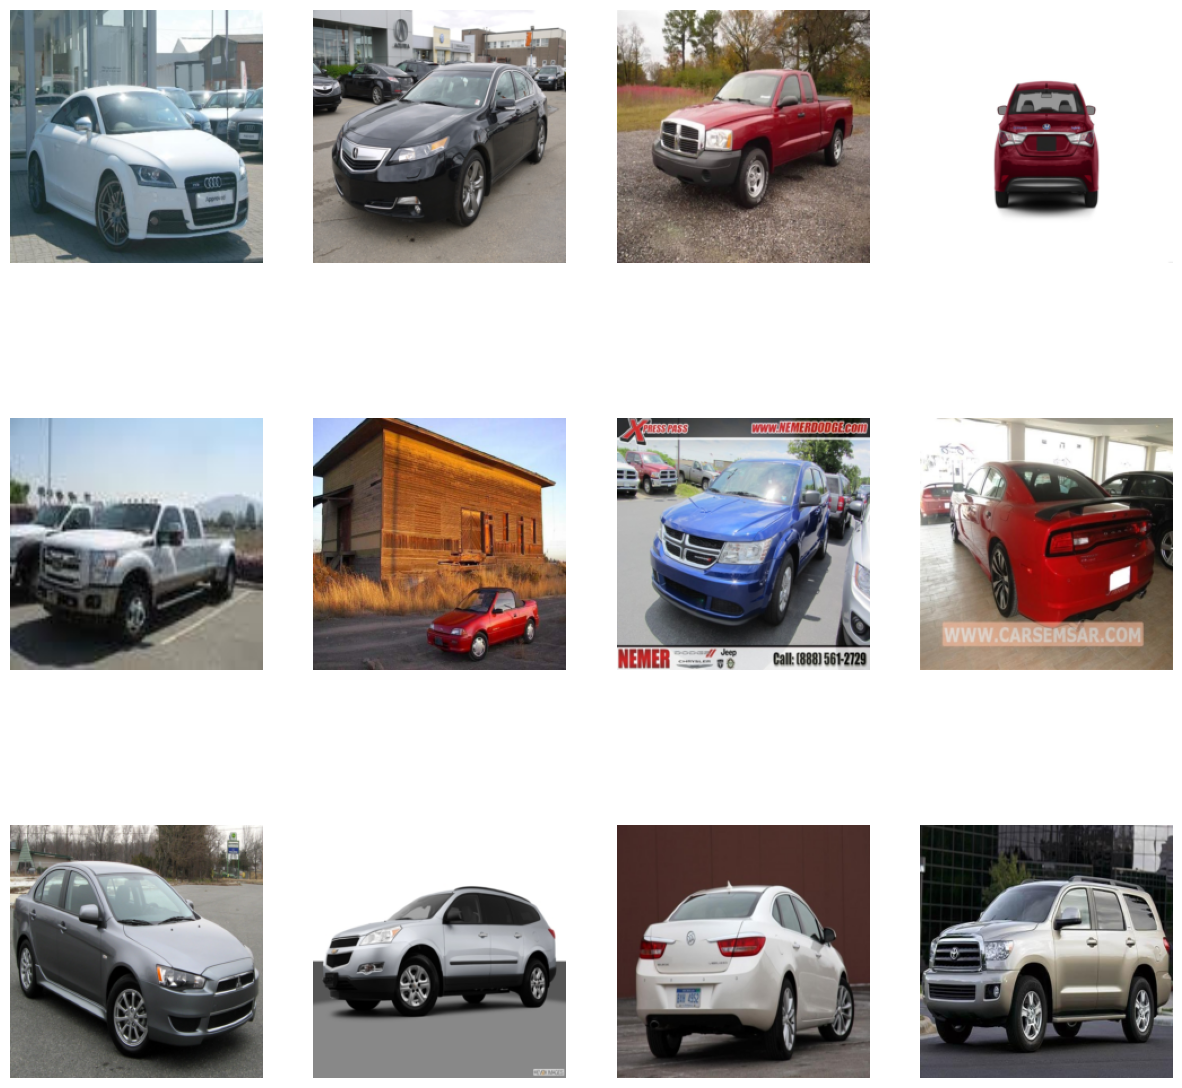

In [6]:

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a consistent size
    transforms.ToTensor()
])

data = ImageFolder(root="data/cars_train/", transform=data_transform, )
# plot some samples
plt.figure(figsize=(15, 15))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(data[i][0].permute(1, 2, 0))
    plt.axis('off')
plt.show()


### implementation ddpmschedule

In [136]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [137]:

def load_transformed_dataset():
    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)  # Escalar para [-1, 1]
    ])
    
    train = ImageFolder(root="data/cars_train/", transform=data_transform)
    test = ImageFolder(root="data/cars_test/", transform=data_transform)

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),  # Voltar para [0, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW para HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Se for um batch, pega a primeira imagem
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))



data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)


#### sampling

In [138]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

### Lib

In [157]:

# Hiperparâmetros
IMG_SIZE = 64
BATCH_SIZE = 128
T = 1000


def forward_diffusion_sample(image, t, device):
    noise = torch.randn_like(image)
    return noise_scheduler.add_noise(image, noise, t).to(device), noise.to(device)



In [170]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)
    ])
    
    train = ImageFolder(root="data/cars_train/", transform=data_transform)
    test = ImageFolder(root="data/cars_test/", transform=data_transform)

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),  # Voltar para [0, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW para HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Se for um batch, pega a primeira imagem
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))


noise_scheduler = DDPMScheduler(num_train_timesteps=T, beta_schedule='squaredcos_cap_v2')


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

#### sampling

In [163]:

@torch.no_grad()
def sample_plot_image():
    x = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)  # Imagem inicial com ruído
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
        t = torch.full((1,), t, device=device, dtype=torch.long)
        residual = model(x, t)
        x = noise_scheduler.step(residual, t, x).prev_sample

        if i % stepsize == 0:
            plt.subplot(1, num_images + 1, int(i / stepsize) + 1)
            show_tensor_image(x.to('cpu'))

    plt.show()


### show data

C:\Users\grego\AppData\Local\Temp\ipykernel_21244\281257895.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


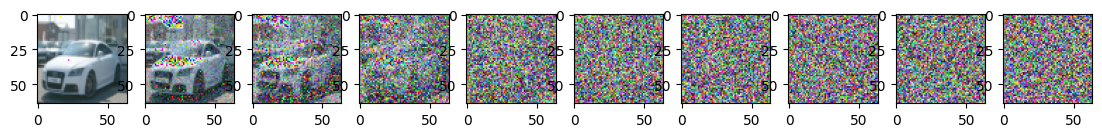

In [171]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t, device)
    show_tensor_image(img.to('cpu'))

### Loss

In [98]:
def get_loss(model, x_0, t, device):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy.to(device), t)
    return F.l1_loss(noise, noise_pred)

### model and training

In [100]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

Epoch 0 | step 000 Loss: 0.6171224117279053 


0it [00:00, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

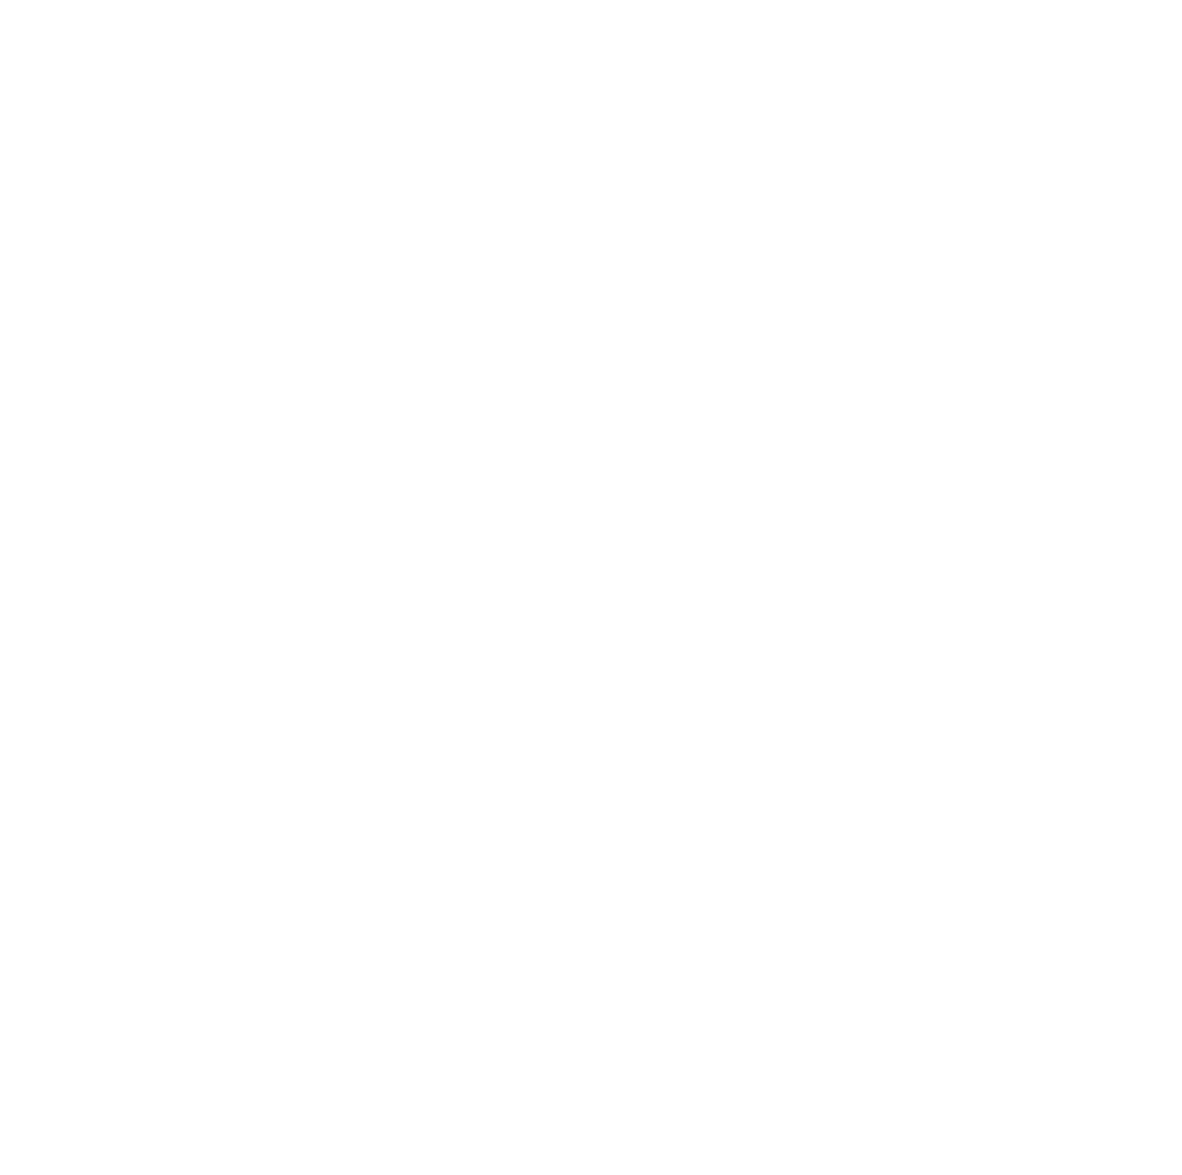

In [111]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t, device)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()